# Default Data Demonstration

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/WISDEM/WOMBAT/main?filepath=examples)

In this example, we'll show what each of the reference plants look like and what results they yield when simulated.

```{important}
The land-based data are expiremental, and should only be used as a starting point for
developing a more robust simulation. Please see the
[default data section of the user guide for further details](index.md#default-data)
```

## Imports

In [1]:
from time import perf_counter

import numpy as np
import pandas as pd

from wombat import Simulation
from wombat.utilities import plot
from wombat.core.library import DEFAULT_DATA

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.options.display.float_format = "{:,.2f}".format

## Initialize the simulations

In [2]:
SEED = 48

lbw_sim = Simulation(DEFAULT_DATA, "base_lbw.yaml", random_seed=SEED)
osw_fixed_sim = Simulation(DEFAULT_DATA, "base_osw_fixed.yaml", random_seed=SEED)
osw_floating_sim = Simulation(DEFAULT_DATA, "base_osw_floating.yaml", random_seed=SEED)

### View the farms

Using the plotting library, we can observe the layout for each of the farms

N turbines: 57, N substations: 1


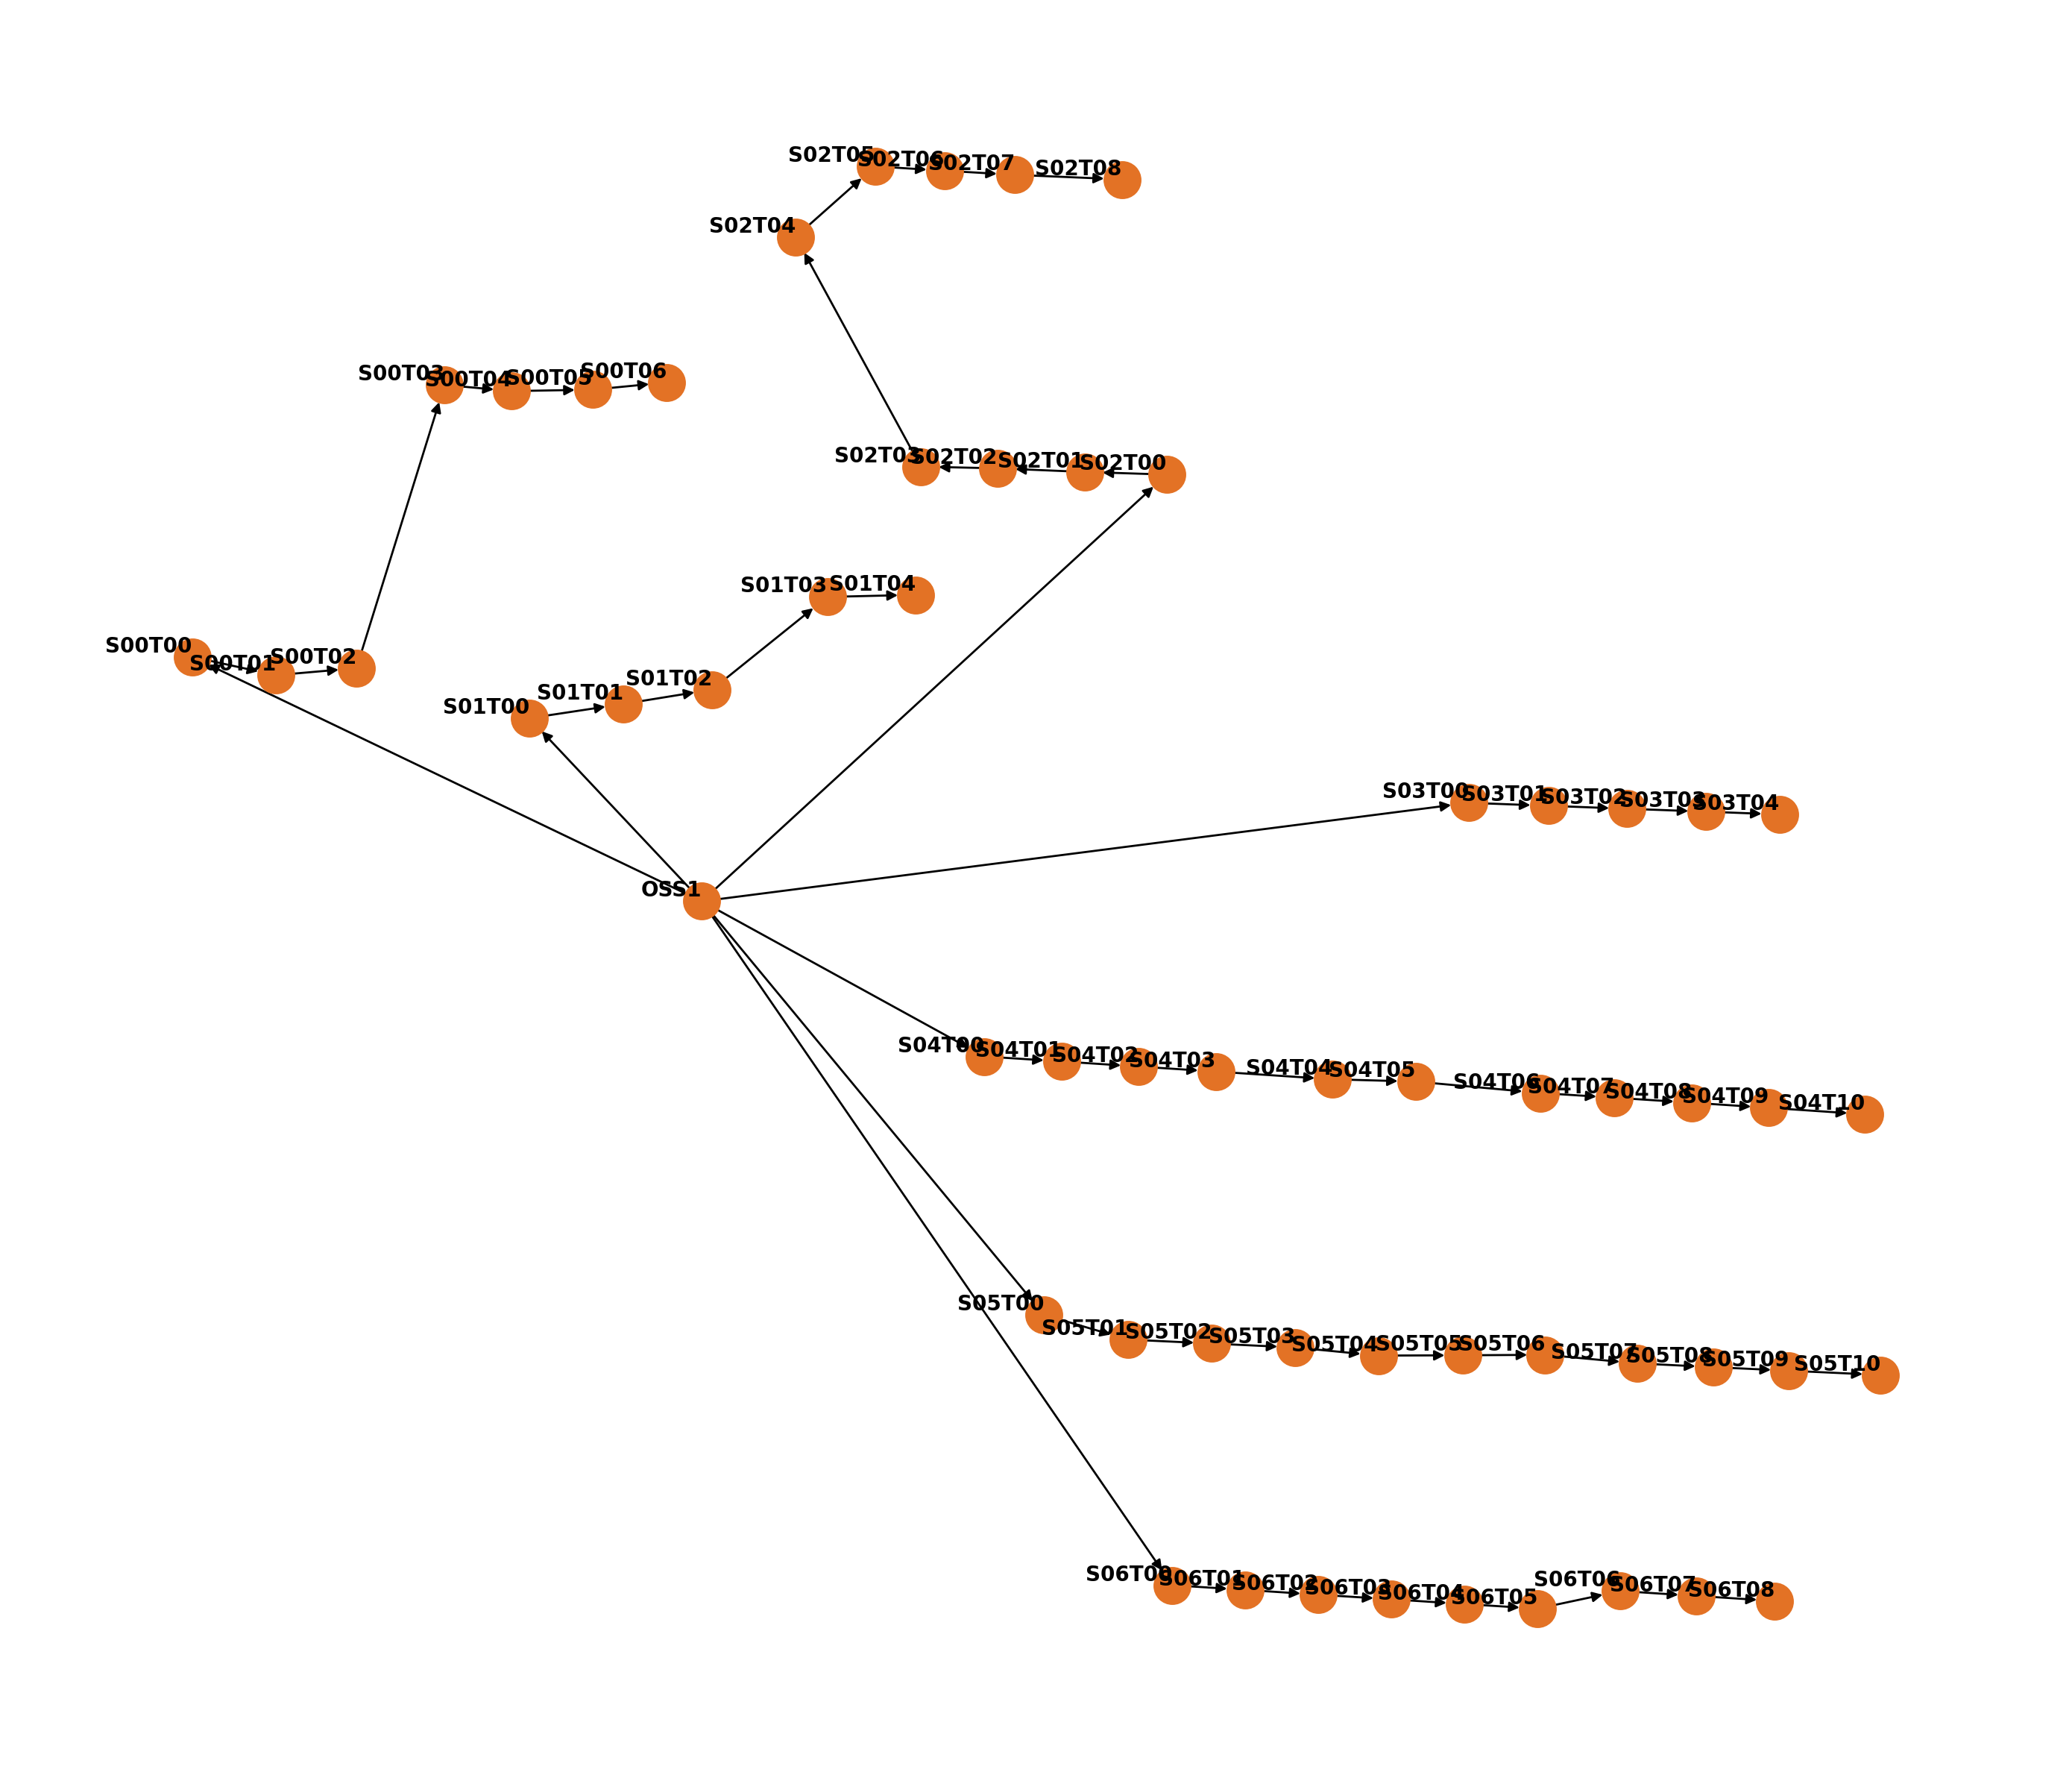

In [3]:
print(
    f"N turbines: {len(lbw_sim.windfarm.turbine_id)}, N substations: {len(lbw_sim.windfarm.substation_id)}"
)
plot.plot_farm_layout(lbw_sim.windfarm)

N turbines: 50, N substations: 1


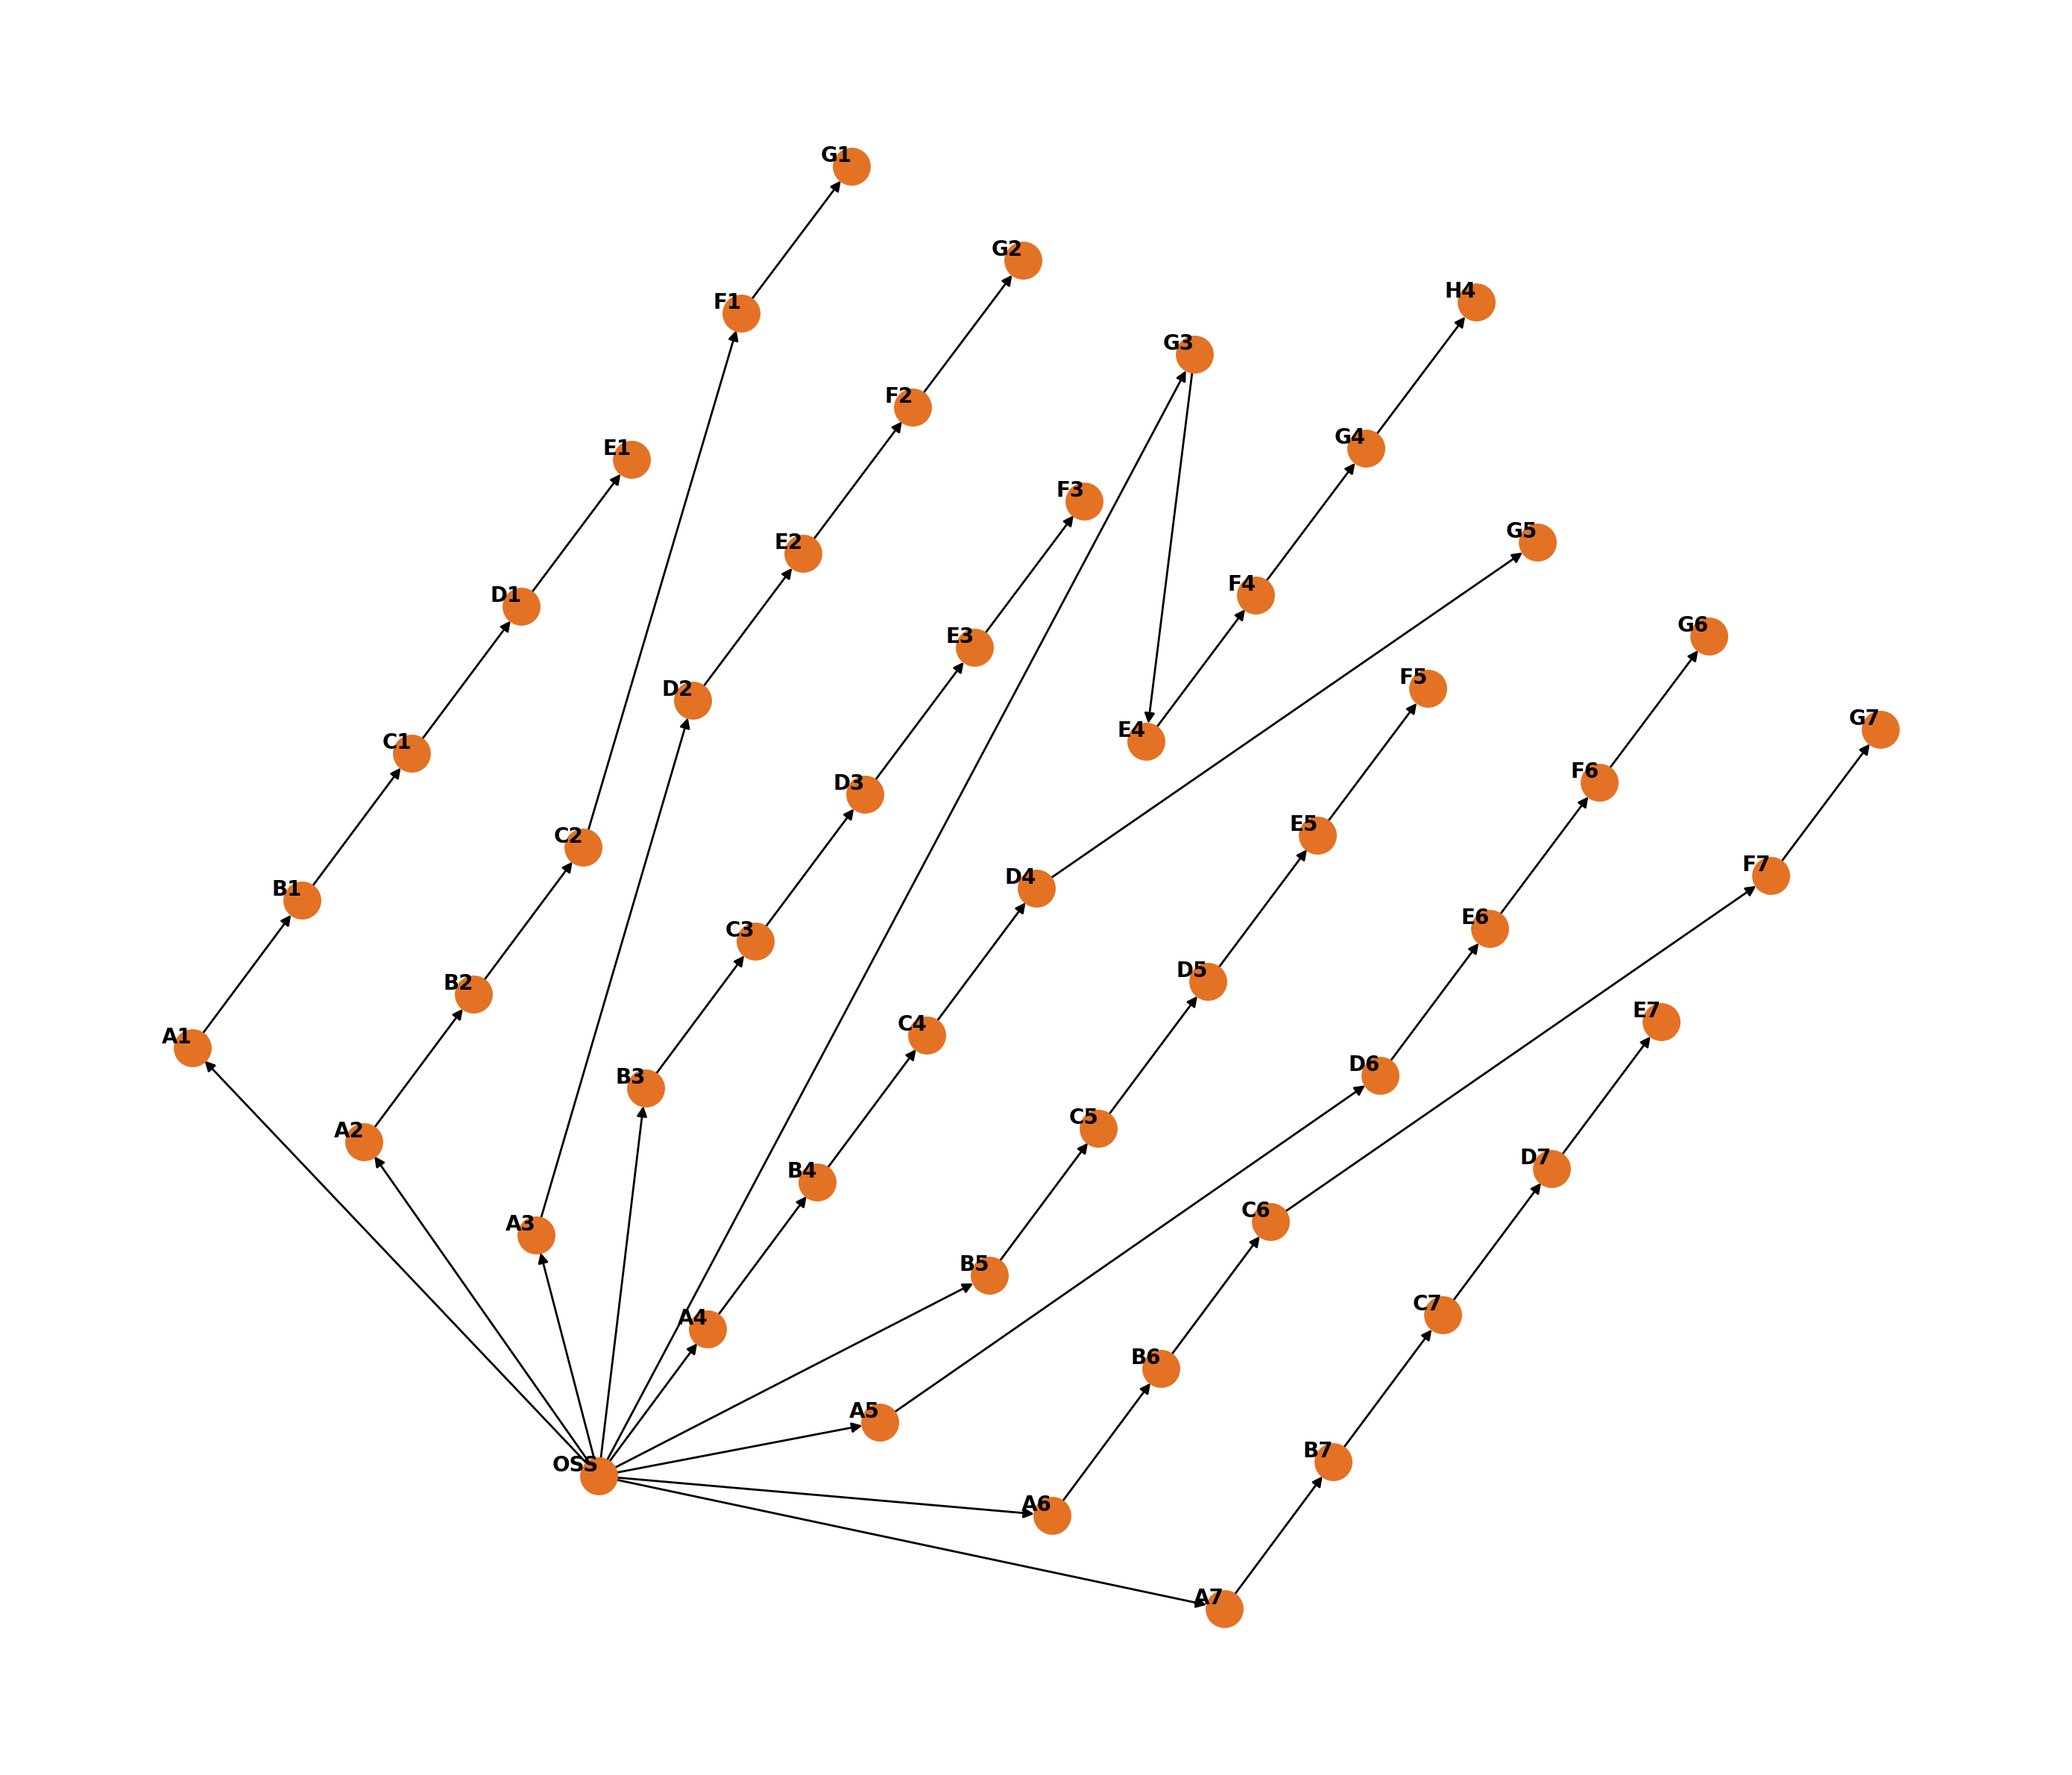

In [4]:
print(
    f"N turbines: {len(osw_fixed_sim.windfarm.turbine_id)}, N substations: {len(osw_fixed_sim.windfarm.substation_id)}"
)
plot.plot_farm_layout(osw_fixed_sim.windfarm)

N turbines: 50, N substations: 1


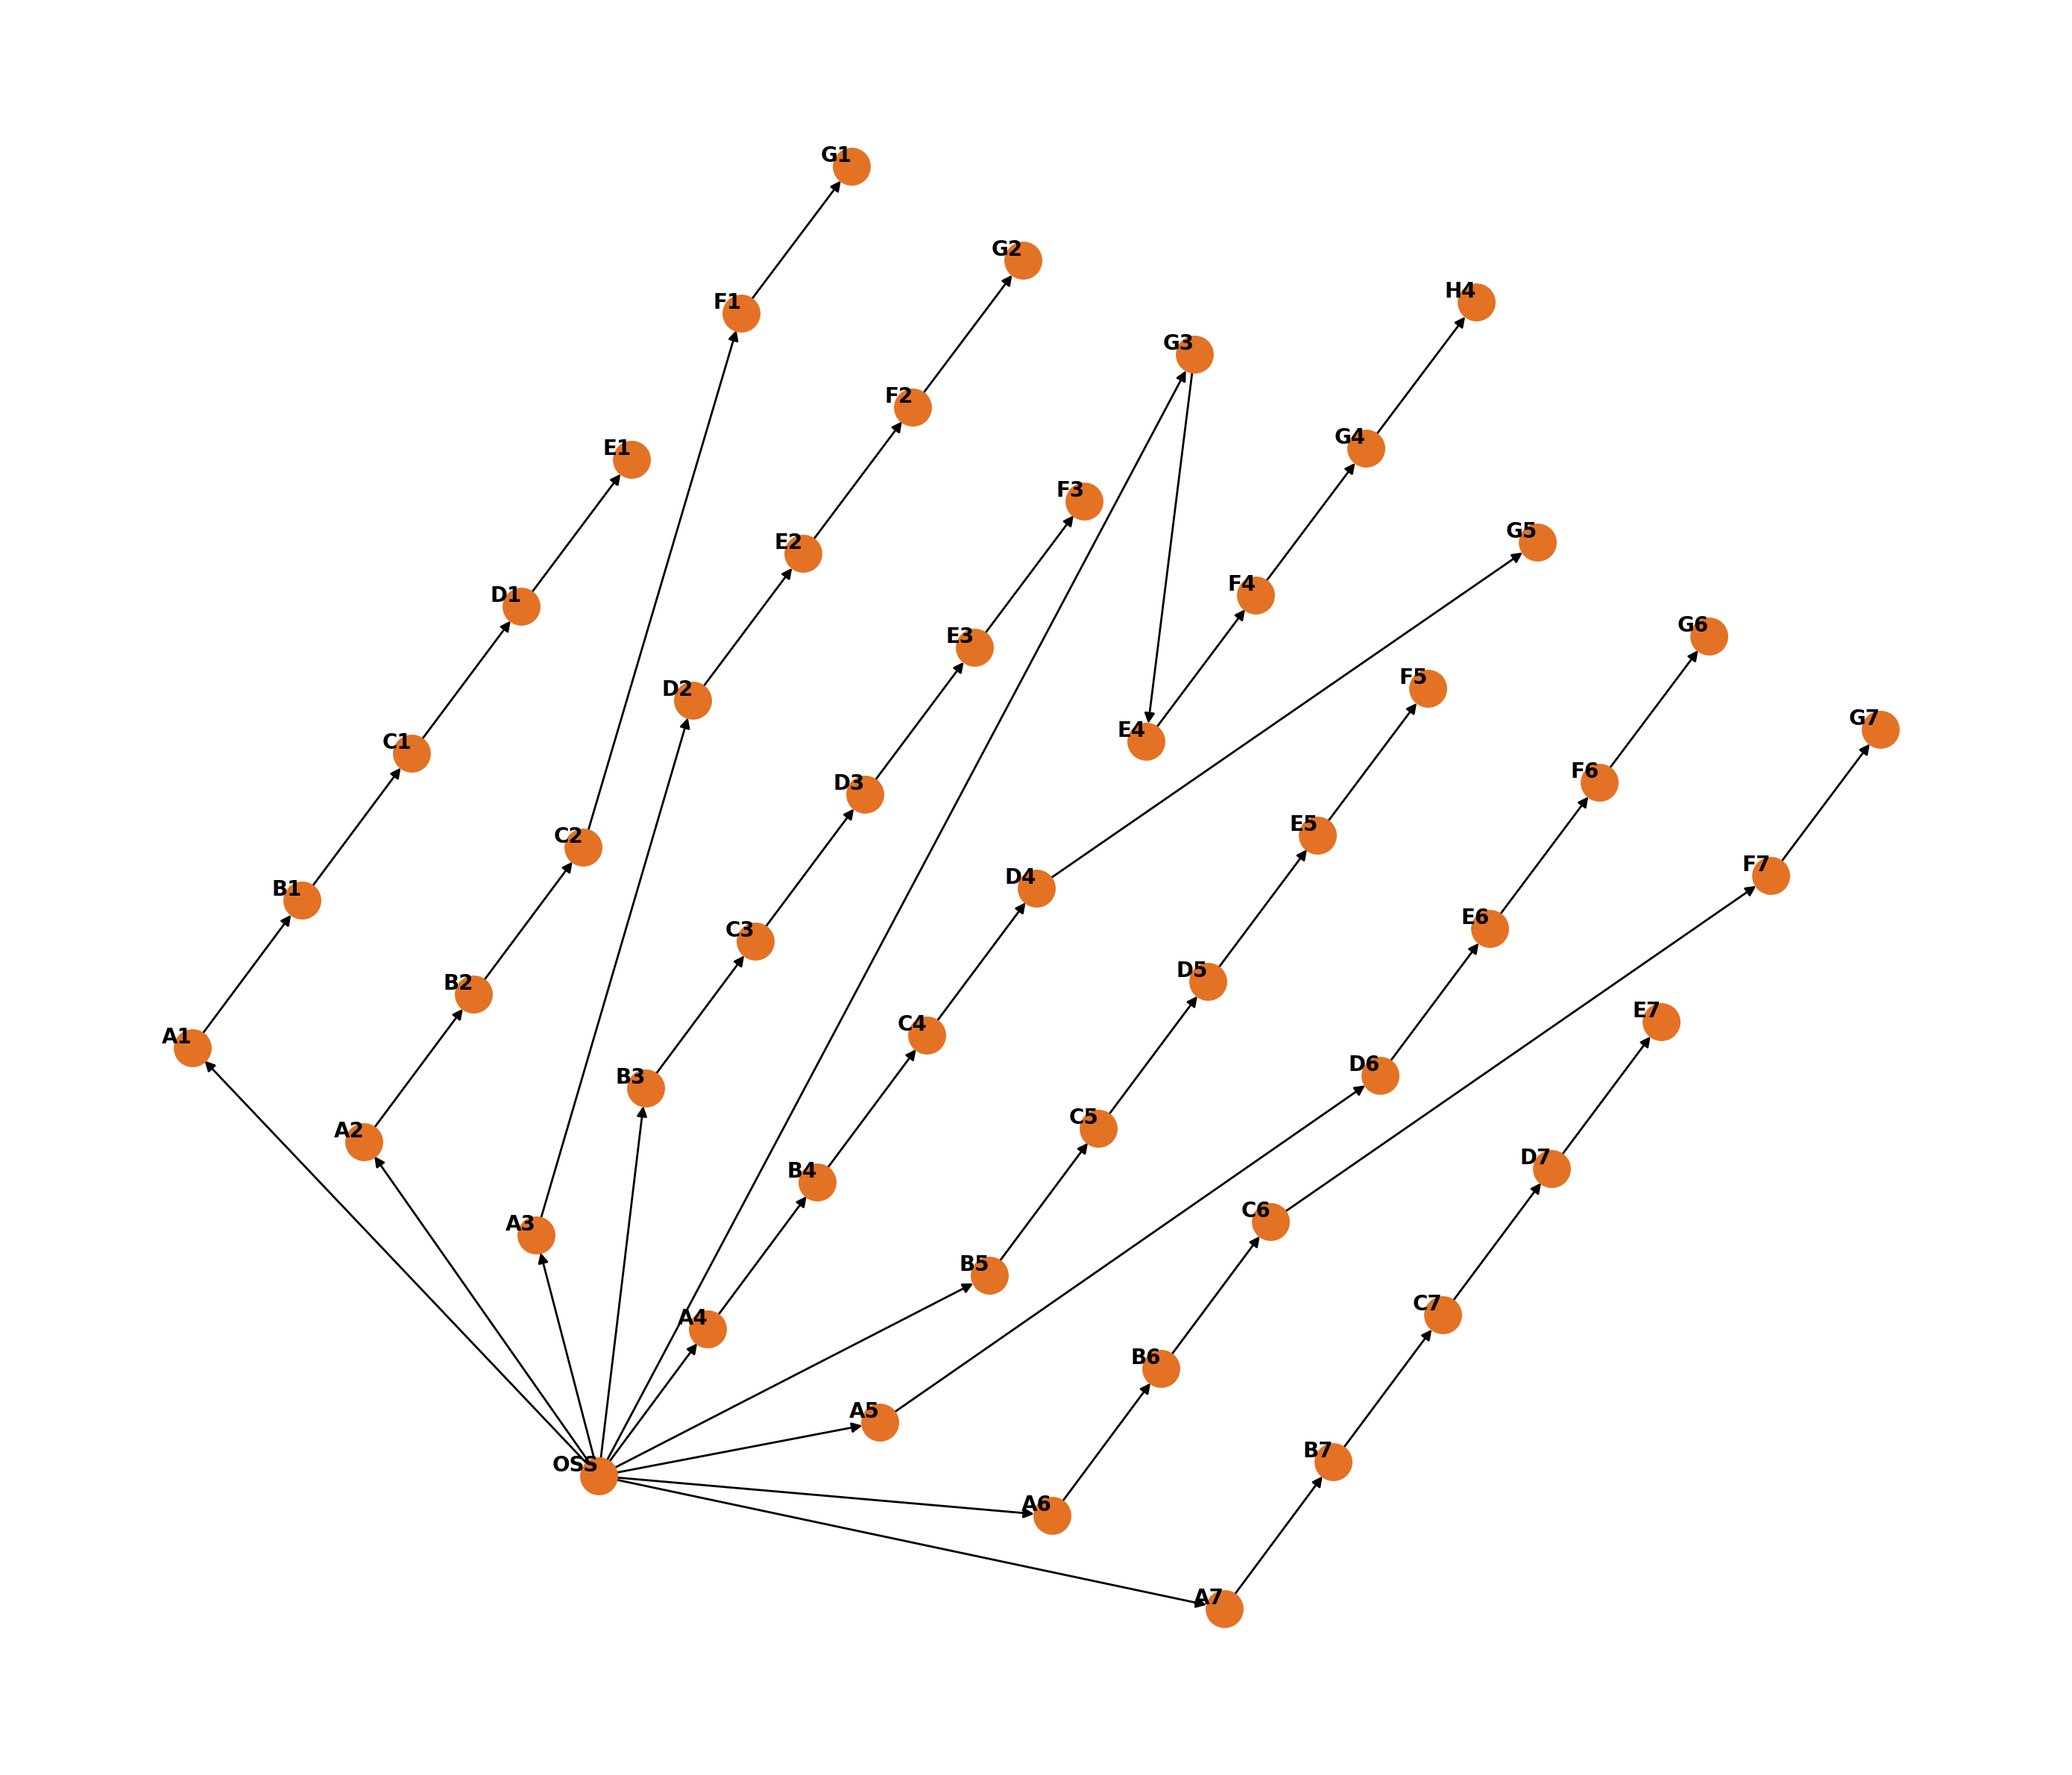

In [5]:
print(
    f"N turbines: {len(osw_floating_sim.windfarm.turbine_id)}, N substations: {len(osw_floating_sim.windfarm.substation_id)}"
)
plot.plot_farm_layout(osw_floating_sim.windfarm)

## Run the simulations

Now we can run all three simulations, delete the simulation log files, and view the run time for
each simulation.

In [6]:
start = perf_counter()
lbw_sim.run(delete_logs=True, save_metrics_inputs=False)
run_time = perf_counter() - start
print(f"Run time: {run_time // 60} minutes {run_time % 60:.1f} seconds")

start = perf_counter()
osw_fixed_sim.run(delete_logs=True, save_metrics_inputs=False)
run_time = perf_counter() - start
print(f"Run time: {run_time // 60} minutes {run_time % 60:.1f} seconds")

start = perf_counter()
osw_floating_sim.run(delete_logs=True, save_metrics_inputs=False)
run_time = perf_counter() - start
print(f"Run time: {run_time // 60} minutes {run_time % 60:.1f} seconds")

Run time: 0.0 minutes 35.9 seconds
Run time: 0.0 minutes 35.5 seconds
Run time: 0.0 minutes 39.8 seconds


Run time: 0.0 minutes 35.5 seconds


Run time: 0.0 minutes 39.8 seconds


### Gather the results

First we will simplify the process of getting results, ensure that all simulations are
20 years, and gather the capacities.

In [7]:
metrics_lbw = lbw_sim.metrics
metrics_osw_fixed = osw_fixed_sim.metrics
metrics_osw_floating = osw_floating_sim.metrics

years_check = (
    lbw_sim.env.simulation_years,
    osw_fixed_sim.env.simulation_years,
    osw_floating_sim.env.simulation_years,
)
print(f"All are 20 years: {all(x == 20 for x in years_check)}")
years = 20

capacities = [  # MW
    metrics_lbw.project_capacity,
    metrics_osw_fixed.project_capacity,
    metrics_osw_floating.project_capacity,
]

columns = ["Metric", "Units", "Land-Based", "OSW-Fixed", "OSW-Floating"]
sort_order = [
    "Project Capacity",
    "Production Based Availability",
    "Total OpEx",
    "Materials",
    "Direct Labor",
    "Port Fees",
    "Fixed Costs (operations, indirect labor, etc.)",
    "Service Equipment",
    "Truck 1",
    "Truck 2",
    "Truck 3",
    "Crawler Crane - 1350 tonnes",
    "Crew Transfer Vessel 1",
    "Crew Transfer Vessel 2",
    "Crew Transfer Vessel 3",
    "Cable Laying Vessel",
    "Diving Support Vessel",
    "Heavy Lift Vessel",
    "Anchor Handling Tug",
    "Tugboat 1",
    "Tugboat 2",
]

All are 20 years: True


Now, we can gather some of the high level availability and cost statistics for each
of the base scenarios.

In [8]:
capacity = pd.DataFrame(
    [["Project Capacity", "MW"] + capacities], columns=columns
).set_index(["Metric", "Units"])

availability = [
    "Production Based Availability",
    "%",
    metrics_lbw.production_based_availability("project", "windfarm").squeeze() * 100,
    metrics_osw_fixed.production_based_availability("project", "windfarm").squeeze()
    * 100,
    metrics_osw_floating.production_based_availability("project", "windfarm").squeeze()
    * 100,
]
availability = pd.DataFrame([availability], columns=columns).set_index(
    ["Metric", "Units"]
)

In [9]:
opex = (
    metrics_lbw.opex("project", "windfarm")
    .rename({0: "Land-Based"})
    .T.join(metrics_osw_fixed.opex("project", "windfarm").rename({0: "OSW-Fixed"}).T)
    .join(
        metrics_osw_floating.opex("project", "windfarm").rename({0: "OSW-Floating"}).T
    )
    / years
    / (np.array(capacities) * 1000)
)
opex.index = [
    "Fixed Costs (operations, indirect labor, etc.)",
    "Port Fees",
    "Service Equipment",
    "Direct Labor",
    "Materials",
    "Total OpEx",
]
opex["Units"] = "$/kw/yr"
opex = opex.set_index("Units", append=True).iloc[::-1]

In [10]:
equipment = (
    metrics_lbw.equipment_costs("project", by_equipment=True)
    .rename({0: "Land-Based"})
    .T.join(
        metrics_osw_fixed.equipment_costs("project", by_equipment=True)
        .rename({0: "OSW-Fixed"})
        .T,
        how="outer",
    )
    .join(
        metrics_osw_floating.equipment_costs("project", by_equipment=True)
        .rename({0: "OSW-Floating"})
        .T,
        how="outer",
    )
    .fillna(0.0)
    / years
    / (np.array(capacities) * 1000)
)
equipment["Units"] = "$/kw/yr"
equipment = equipment.set_index("Units", append=True)

/var/folders/q5/tfpytqxn0r396dfg7rk5sj8rwq9tvv/T/ipykernel_43581/2109753505.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0.0)


With each of the core costs gathered, we can combine them into a single DataFrame and
view them.

In [11]:
results = pd.concat([capacity, availability, opex, equipment]).loc[sort_order]
results

,,Land-Based,OSW-Fixed,OSW-Floating
,Units,,,
Project Capacity,MW,199.50,600.00,600.00
Production Based Availability,%,97.44,93.74,92.52
Total OpEx,$/kw/yr,35.73,123.42,145.91
Materials,$/kw/yr,1.66,2.13,3.39
Direct Labor,$/kw/yr,0.00,0.00,0.00
Port Fees,$/kw/yr,0.00,0.50,16.74
"Fixed Costs (operations, indirect labor, etc.)",$/kw/yr,18.81,47.38,50.94
Service Equipment,$/kw/yr,15.25,73.41,74.84
Truck 1,$/kw/yr,0.04,0.00,0.00
